In [1]:
!pip install timesfm
!pip install git+https://github.com/DynaDojo/dynadojo@dev

  Using cached nvidia_nvjitlink_cu12-12.6.20-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 6.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of googleapis-common-protos to determine which version is compatible with other requirements. This could take a while.
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7

  Cloning https://github.com/DynaDojo/dynadojo (to revision dev) to /tmp/pip-req-build-7xbwwicl
  Running command git clone --filter=blob:none --quiet https://github.com/DynaDojo/dynadojo /tmp/pip-req-build-7xbwwicl
  Running command git checkout -b dev --track origin/dev
  Switched to a new branch 'dev'
  Branch 'dev' set up to track remote branch 'dev' from 'origin'.
  Resolved https://github.com/DynaDojo/dynadojo to commit a1d9f4abcece26a849aa2399e1bc82a01382ebe0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 4.4 MB/s eta 0:00:00
  Created wheel for DynaDojo: filename=dynadojo-0.1.0-py3-none-any.whl size=89463 sha256=f517d18f472146cd553ebd2d02a4618c723febc8432e5df059e7199dc27f4c34
  Stored in directory: /tmp/pip-ephem-wheel-cache-bfibta4o/wheels/7b/50/8d/06b5bbf5a830c0e022656cbd28ea17c07210265b3bc2ea36d6
Successfully built DynaDojo
  Atte

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from dynadojo.systems.lorenz import LorenzSystem
from dynadojo.systems.lv import PreyPredatorSystem
from dynadojo.systems.lds import LDSystem
from dynadojo.systems.kuramoto import KuramotoSystem
from dynadojo.wrappers import SystemChecker, AlgorithmChecker
from dynadojo.baselines.dnn import DNN
from dynadojo.utils.lds import plot

(<Figure size 640x480 with 1 Axes>, <Axes3D: >)

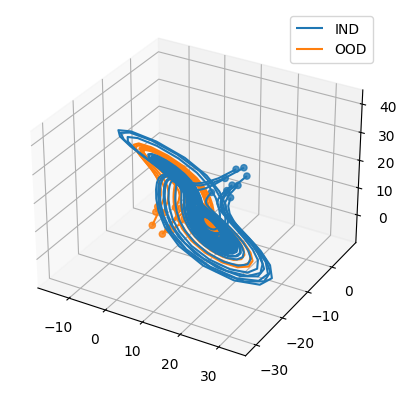

In [ ]:
latent_dim = 3 # Number of variables
embed_dim = latent_dim
n = 50  # Number of trajectories in train set
test_size = 10  # Number of trajectories in test set
leadin = 10
timesteps = 500 # Timesteps in each trajectory
system = SystemChecker(LorenzSystem(latent_dim, embed_dim, noise_scale=0, seed=1912,
                                    sigma=10, r=28, a_squared=1/2.0, b=8.0/3.0,
                                    t_range=(0, 10),
                                    ))
# system = SystemChecker(LDSystem(latent_dim, embed_dim, noise_scale=0, seed=1912))
# system = SystemChecker(PreyPredatorSystem(latent_dim, embed_dim))
# system = SystemChecker(KuramotoSystem(embed_dim, embed_dim))
x0 = system.make_init_conds(n)
y0 = system.make_init_conds(test_size, in_dist=False)
x = system.make_data(x0, timesteps=timesteps)
y = system.make_data(y0, timesteps=timesteps, noisy=False)
plot([x, y], target_dim=min(latent_dim, 3), labels=["IND", "OOD"], max_lines=test_size)

In [ ]:
from dynadojo.abstractions import AbstractAlgorithm
import timesfm
from typing import Any, Optional, List
import numpy as np
import enum

class TimesFMFrequency(enum.Enum):
  T = 0
  W = 1
  Q = 2

class TimesFMSingleton(object):
  def __new__(cls, context_len: int = 512, horizon_len: int = 128, backend: str = "gpu"):
    if not hasattr(cls, 'instance'):
      cls.instance = super(TimesFMSingleton, cls).__new__(cls)
      cls.instance.tfm = timesfm.TimesFm(
        context_len=context_len,
        horizon_len=horizon_len,
        input_patch_len=32, # Fixed for pretrained checkpoint.
        output_patch_len=128, # Fixed for pretrained checkpoint.
        num_layers=20, # Fixed for pretrained checkpoint.
        model_dims=1280, # Fixed for pretrained checkpoint.
        backend=backend)
      cls.instance.tfm.load_from_checkpoint(repo_id="google/timesfm-1.0-200m")

    return cls.instance

  def forecast(self, x0seq: Any, freqs: List[TimesFMFrequency], **kwargs):
    return self.__class__.instance.tfm.forecast(x0seq, freq=[f.value for f in freqs])

In [ ]:
class TimesFMAlgorithmPretrained(AbstractAlgorithm):
  def __init__(self, embed_dim: int,
               timesteps: int,
               max_control_cost: float,
               seed: Optional[int] = None,
               context_len: int = 512,
               horizon_len: int = 128,
               backend: str = "gpu",
               freq: TimesFMFrequency = TimesFMFrequency.T,
               **kwargs):
    super().__init__(embed_dim, timesteps, max_control_cost, seed, **kwargs)
    # To handle the batch forecast case, support a horizon of embed_dim*horizon_len.
    self.tfm = TimesFMSingleton(context_len=context_len, horizon_len=embed_dim*horizon_len,backend=backend)
    self.freq = freq

  def fit(self, x: np.ndarray, **kwargs: Any) -> None:
    """
      No-op, since the foundation model is already pre-trained.

      Parameters
      ----------
      x : np.ndarray
          (n, timesteps, embed_dim) Trajectories tensor.
      **kwargs
          Additional keyword arguments.
    """
    # TODO consider use of fine-tuning API here: https://github.com/google-research/timesfm/blob/master/notebooks/finetuning.ipynb
    return None

  def predict(self, x0: np.ndarray, timesteps: int, **kwargs: Any) -> np.ndarray:
    """
    Predict how initial conditions matrix evolves over a given number of timesteps.

    Parameters
    ----------
    x0 : np.ndarray
        (n, embed_dim) initial conditions matrix - IGNORED
    timesteps : int
        timesteps per predicted trajectory
    x0seq : np.ndarray
        (n, init_timesteps, embed_dim) initial trajectories tensor
    forecast_batch: bool
        If true, predict the trajectory [(x0,y0,z0),(x1,y1,z1),...] by having the model forecast [x0,y0,z0,x1,y1,z1,...]
    **kwargs
        Additional keyword arguments.

    Returns
    -------
    np.ndarray
        (n, timesteps, embed_dim) trajectories tensor
    """
    x0seq=kwargs.get('x0seq', None) # (n, init_timesteps, embed_dim)
    forecast_batch=kwargs.get('forecast_batch', False)
    n, init_timesteps, embed_dim = x0seq.shape
    if not forecast_batch:
      # Perform univariate forecasting for each dimension of the trajectory.
      # This is likely to be inaccurate due to the model's lack of awareness of
      # correlations in each component of the trajectory
      x0seq_reshaped = x0seq.transpose(0, 2, 1).reshape((n*embed_dim, init_timesteps)) # (n*embed_dim, init_timesteps))
      freqs = [self.freq] * (n*embed_dim) # (n * embed_dim,)
      point_forecast, _ = self.tfm.forecast(x0seq_reshaped, freqs=freqs) # (n * embed_dim, embed_dim*horizon_len)
      return point_forecast[:, :timesteps].reshape((n, embed_dim, timesteps)).transpose(0, 2, 1) # (n, timesteps, embed_dim)
    else:
      # Reshape the trajectory [(x0,y0,z0),(x1,y1,z1),...] as [x0,y0,z0,x1,y1,z1,...] and feed this sequence to the foundation model.
      x0seq_reshaped = x0seq.reshape(n, init_timesteps*embed_dim) # (n, init_timesteps*embed_dim)
      freqs = [self.freq] * n
      point_forecast, _ = self.tfm.forecast(x0seq_reshaped, freqs=freqs) # (n, embed_dim*horizon_len)
      return point_forecast[:, :(embed_dim*timesteps)].reshape((n, timesteps, embed_dim)) # (n, timesteps, embed_dim)

In [ ]:
for forecast_batch in (False, True):
  for freq in (TimesFMFrequency.T, TimesFMFrequency.W, TimesFMFrequency.Q):
    for leadin in (10, 25, 50):
      model = AlgorithmChecker(TimesFMAlgorithmPretrained(embed_dim, timesteps, max_control_cost=0, seed=42, freq=freq))
      y_pred = model.predict(y0, timesteps-leadin, x0seq=y[:,:leadin,:],forecast_batch=forecast_batch)
      y_err = system.calc_error(y[:, leadin:, :], y_pred)
      print(f"{y_err=}")
      plot([y_pred, y[:, leadin:, :]], target_dim=min(3, latent_dim), labels=["pred", "true"], max_lines=15, title=f"{forecast_batch=},{freq=},{leadin=},{y_err=}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

(…)oint_1100000/descriptor/descriptor.pbtxt:   0%|          | 0.00/499 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.73k [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

(…)nts/checkpoint_1100000/metadata/metadata:   0%|          | 0.00/43.9k [00:00<?, ?B/s]

checkpoint:   0%|          | 0.00/814M [00:00<?, ?B/s]

Constructing model weights.


Constructed model weights in 4.82 seconds.
Restoring checkpoint from /root/.cache/huggingface/hub/models--google--timesfm-1.0-200m/snapshots/8775f7531211ac864b739fe776b0b255c277e2be/checkpoints.


ERROR:absl:For checkpoint version > 1.0, we require users to provide
          `train_state_unpadded_shape_dtype_struct` during checkpoint
          saving/restoring, to avoid potential silent bugs when loading
          checkpoints to incompatible unpadded shapes of TrainState.


Restored checkpoint in 1.60 seconds.
Jitting decoding.
Jitted decoding in 38.96 seconds.


ValueError: cannot reshape array of size 11520 into shape (10,3,490)